# Final Project - TOPICS IN DATA SCIENCE CS 5661

## Early Skin Cancer Detection: Bringing Dermatology to Everyone

AI-driven smartphone-based skin cancer detection can democratize early diagnosis, improving global healthcare accessibility and patient outcomes.

Team Members: Nikhil Dhiman, Yamini Mandadi, Jaydeep Dhirubhai Gondaliya, Sudipta Bhatta, Akash Saraf, Saurabh Wankhade

In [1]:
# Activates the Python virtual environment located at cs5661/bin/activate
!source cs5661/bin/activate

In [2]:
!pip show tensorflow keras keras-cv


Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/ndhiman/.local/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 
---
Name: keras
Version: 3.3.3
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /home/ndhiman/.local/lib/python3.10/site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: tensorflow
---
Name: keras-cv
Version: 0.9.0
Summary: Industry-strength computer Vision extensions for Keras.
H

In [3]:
# Set environment variables to configure Keras backend and suppress TensorFlow logs
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'    

# Core Keras and TensorFlow libraries
import keras_cv                              
import keras                                  
from keras import ops                         
import tensorflow as tf                      

# Visualization
import matplotlib.pyplot as plt               

# Data handling and utilities
import cv2                                    
import pandas as pd                           
import numpy as np                           
from glob import glob                         
from tqdm.notebook import tqdm                
import joblib                                 
import h5py                                   

# Scikit-learn for model validation and preprocessing
from sklearn.utils.class_weight import compute_class_weight  
from sklearn.model_selection import StratifiedGroupKFold     

# Other utilities
import math                                   

In [4]:
# Print the version numbers of the key libraries to ensure compatibility and reproducibility
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.16.1
Keras: 3.3.3
KerasCV: 0.9.0


#### Configuration 
For models:
- EfficientNet v2 b0
- EfficientNet v2 b1
- Resnet50
- Mobilenet v3

In [5]:
# Configuration class to store global hyperparameters and settings for training and evaluation
class config:
    verbose = 1
    seed = 42
    neg_sample = 0.01
    pos_sample = 5.0
    # List of model names to iterate over for training/benchmarking
    preset_list = ["efficientnetv2_b0_imagenet", "efficientnetv2_b2_imagenet", "resnet50_imagenet", "mobilenet_v3_large_imagenet"]
    # Will be set dynamically based on selected model
    image_size = None
    epochs = 8
    batch_size = 256
    lr_mode = "cos"
    class_names = ['target']
    num_classes = 1


In [6]:
# Specifies the expected input image size for each pretrained model.
# Note: 128x128 is used for EfficientNet variants as a trade-off between speed and performance,
# while models like ResNet50 and MobileNetV3 use their standard 224x224 input size.
preset_image_sizes = {
    "efficientnetv2_b0_imagenet": [128, 128],
    "efficientnetv2_b2_imagenet": [128, 128],
    "resnet50_imagenet": [224, 224],
    "mobilenet_v3_large_imagenet": [224, 224],
}

#### Loading Data

In [7]:
# Load training metadata CSV and forward-fill missing values.
# 'low_memory=False' ensures proper dtype inference across large mixed-type columns.
df = pd.read_csv('train-metadata.csv', low_memory=False).ffill()
display(df.head(2))

testing_df = pd.read_csv('test-metadata.csv', low_memory=False).ffill()
display(testing_df.head(2))


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY


#### Data Pre-Processing

In [8]:
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True) * 100)

# Perform stratified sampling to address class imbalance:
# - Downsample the majority class (target == 0) using a fraction defined in config.neg_sample.
# - Upsample the minority class (target == 1) with replacement using config.pos_sample.
# - Use a fixed random_state from config for reproducibility.
positive_df = df.query("target==0").sample(frac=config.neg_sample, random_state=config.seed)
negative_df = df.query("target==1").sample(frac=config.pos_sample, replace=True, random_state=config.seed)
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0)

print("\nClass Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True) * 100)


Class Distribution Before Sampling (%):


target
0    99.902009
1     0.097991
Name: proportion, dtype: float64


Class Distribution After Sampling (%):


target
0    67.09645
1    32.90355
Name: proportion, dtype: float64

In [9]:
# Compute class weights to handle class imbalance during model training.
# 'balanced' mode assigns weights inversely proportional to class frequencies.
# This ensures that minority classes are given higher importance.
# The result is converted to a dictionary mapping class labels to their weights.
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.7451959071624656, 1: 1.519592875318066}


In [10]:
# Open HDF5 files containing preprocessed image data for training/validation and testing.
# These files store datasets in a binary format optimized for fast I/O and large-scale data handling.
# Mode 'r' opens the files in read-only mode to prevent accidental modification.
training_validation_hdf5 = h5py.File("train-image.hdf5", 'r')
testing_hdf5 = h5py.File("test-image.hdf5", 'r')

Byte String: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'....
Image:


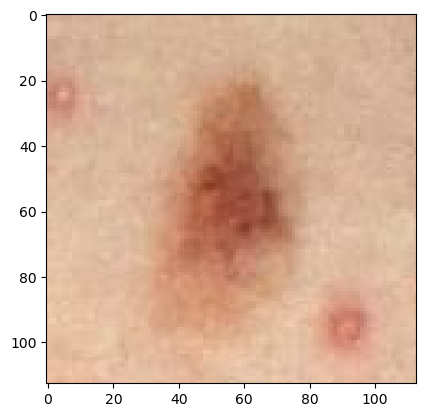

In [11]:
# Retrieve the first image's ISIC ID from the dataframe.
isic_id = df.isic_id.iloc[0]
# Access the corresponding byte string from the HDF5 file.
# The image is stored as a compressed byte stream (e.g., JPEG format).
byte_string = training_validation_hdf5[isic_id][()]
print(f"Byte String: {byte_string[:20]}....")
# Decode the byte string into a NumPy array of uint8 values.
nparr = np.frombuffer(byte_string, np.uint8)
# Decode the image using OpenCV (assumes the image was encoded, e.g., in JPEG format).
# Convert from BGR (OpenCV default) to RGB for correct display with matplotlib.
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1]
# Display the decoded image.
print("Image:")
plt.imshow(image)
plt.show()


In [12]:
# Reset the dataframe index and initialize a 'fold' column to store fold assignments.
df = df.reset_index(drop=True)
df["fold"] = -1
# Create a StratifiedGroupKFold splitter to ensure:
# - Stratification based on 'target' (i.e., preserving class distribution across folds).
# - Grouping by 'patient_id' to prevent data leakage (ensures all samples from one patient are in the same fold).
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=config.seed)
# Assign fold numbers to the 'fold' column based on the stratified group split.
for i, (train_idx, val_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.patient_id)):
    df.loc[val_idx, "fold"] = int(i)
# Use fold 0 as the validation set and the remaining folds as the training set.
training_df = df.query("fold!=0")
validation_df = df.query("fold==0")
# Print the number of samples in training and validation sets.
print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)}")

# Num Train: 4706 | Num Valid: 1266


In [13]:
training_df.target.value_counts()

target
0    3088
1    1618
Name: count, dtype: int64

In [14]:
validation_df.target.value_counts()

target
0    919
1    347
Name: count, dtype: int64

In [15]:
# Define feature columns for model input:
# - CATEGORICAL_COLUMNS: List of categorical metadata features (e.g., patient sex, anatomical site).
# - NUMERIC_COLUMNS: List of continuous/numerical features derived from clinical or image-based data.
CATEGORICAL_COLUMNS = ["sex", "anatom_site_general", "tbp_tile_type", "tbp_lv_location"]
NUMERIC_COLUMNS = [
    "age_approx", "tbp_lv_nevi_confidence", "clin_size_long_diam_mm",
    "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio", "tbp_lv_color_std_mean",
    "tbp_lv_deltaLBnorm", "tbp_lv_minorAxisMM"
]
# Combine categorical and numeric columns into a single feature list for model use.
FEAT_COLS = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS

#### Model Training 

In [16]:
# Builds an image augmentation function using KerasCV layers.
# Applies random cutout and horizontal flip with 50% probability each.
# Returns a callable that modifies the "images" key in the input dictionary.
def build_augmenter():
    aug_layers = [
        keras_cv.layers.RandomCutout(height_factor=(0.02, 0.06), width_factor=(0.02, 0.06)),
        keras_cv.layers.RandomFlip(mode="horizontal"),
    ]
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    def augment(inp, label):
        aug_data = {"images": inp["images"]}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label

    return augment

# Builds a decoding function for JPEG-encoded images.
# If `with_labels` is True, it also processes the labels into the required shape.
# Images are resized to `target_size` and normalized to [0, 1].
def build_decoder(with_labels=True, target_size=[128,128]):
    def decode_image(inp):
        image = tf.io.decode_jpeg(inp["images"])
        image = tf.image.resize(image, size=tf.convert_to_tensor(target_size, dtype=tf.int32), method="area")
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, [*target_size, 3])
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        return tf.reshape(label, [num_classes])

    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, config.num_classes)
        return (inp, label)

    return decode_with_labels if with_labels else decode_image

# Builds a TensorFlow dataset from ISIC image byte strings stored in HDF5,
# along with optional features and labels.
# Applies decoding, optional augmentation, caching, shuffling, batching, and prefetching.
def build_dataset(
    isic_ids,
    hdf5,
    features,
    labels=None,
    batch_size=32,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    shuffle=1024,
    cache=True,
    drop_remainder=False,
):
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    images = [hdf5[isic_id][()] for isic_id in tqdm(isic_ids, desc="Loading Images ")]
    inp = {"images": images, "features": features}
    slices = (inp, labels) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    if cache:
        ds = ds.cache()
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    if shuffle:
        ds = ds.shuffle(shuffle, seed=config.seed)
        opt = tf.data.Options()
        opt.deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    if augment:
        ds = ds.map(augment_fn, num_parallel_calls=AUTO)
    ds = ds.prefetch(AUTO)
    return ds


In [17]:
# Define a Keras FeatureSpace to preprocess structured metadata features.
# - Categorical string features will be one-hot encoded.
# - Float features are either discretized (for approximate age) or normalized.
# - All processed features are concatenated into a single output tensor.
feature_space = keras.utils.FeatureSpace(
    features={
        "sex": "string_categorical",
        "anatom_site_general": "string_categorical",
        "tbp_tile_type": "string_categorical",
        "tbp_lv_location": "string_categorical",
        "age_approx": "float_discretized",
        "tbp_lv_nevi_confidence": "float_normalized",
        "clin_size_long_diam_mm": "float_normalized",
        "tbp_lv_areaMM2": "float_normalized",
        "tbp_lv_area_perim_ratio": "float_normalized",
        "tbp_lv_color_std_mean": "float_normalized",
        "tbp_lv_deltaLBnorm": "float_normalized",
        "tbp_lv_minorAxisMM": "float_normalized",
    },
    output_mode="concat",
)

In [18]:
# Returns a custom Keras learning rate scheduler callback based on a chosen decay strategy.
# Supports ramp-up, optional sustain phase, and three decay modes: exponential, step, and cosine.
# - lr_start: Initial learning rate.
# - lr_max: Maximum learning rate, scaled by batch size.
# - lr_min: Minimum learning rate after decay.
# - lr_ramp_ep: Number of warm-up epochs to linearly increase LR.
# - lr_sus_ep: Optional sustain phase at lr_max before decay begins.
# - lr_decay: Decay factor for exponential/step decay.
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 2.5e-5, 5e-6 * batch_size, 0.8e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            return (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            return lr_max
        elif mode == 'exp':
            return (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step':
            return lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            return (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min

    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('Epoch'); plt.ylabel('LR')
        plt.title('Learning Rate Schedule')
        plt.grid(True)
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)


In [19]:
# AUC
auc = keras.metrics.AUC()

# Loss
loss = keras.losses.BinaryCrossentropy(label_smoothing=0.02)

In [20]:
# Initialize a dictionary to store training histories for each model preset.
results = {}

# Iterate over each model architecture preset defined in the config.
for preset in config.preset_list:
    print(f"\n=== Training with {preset} ===")
    # Set random seed for reproducibility.
    keras.utils.set_random_seed(config.seed)
    # Update image size for the current preset.
    config.image_size = preset_image_sizes[preset]
    
    # === Dataset Preparation ===
    print("# Preparing dataset for", preset)
    print("# Training:")
    
    # Prepare training dataset.
    training_features = dict(training_df[FEAT_COLS])
    training_ids = training_df.isic_id.values
    training_labels = training_df.target.values
    training_ds = build_dataset(
        training_ids, training_validation_hdf5, training_features,
        training_labels, batch_size=config.batch_size,
        shuffle=True, augment=True,
        decode_fn=build_decoder(with_labels=True, target_size=config.image_size)
    )
    
    # Prepare validation dataset.
    print("# Validation:")
    validation_features = dict(validation_df[FEAT_COLS])
    validation_ids = validation_df.isic_id.values
    validation_labels = validation_df.target.values
    validation_ds = build_dataset(
        validation_ids, training_validation_hdf5, validation_features,
        validation_labels, batch_size=config.batch_size,
        shuffle=False, augment=False,
        decode_fn=build_decoder(with_labels=True, target_size=config.image_size)
    )

    # Adapt the feature space on training data (structure features only).
    training_ds_with_no_labels = training_ds.map(lambda x, _: x["features"])
    feature_space.adapt(training_ds_with_no_labels)
    
    # Preview preprocessed structured features.
    for x, _ in training_ds.take(1):
        preprocessed_x = feature_space(x["features"])
        print("preprocessed_x.shape:", preprocessed_x.shape)
        print("preprocessed_x.dtype:", preprocessed_x.dtype)
    
    # Apply the feature space transformation to both training and validation datasets.
    training_ds = training_ds.map(
        lambda x, y: (
            {"images": x["images"], "features": feature_space(x["features"])}, y
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    validation_ds = validation_ds.map(
        lambda x, y: (
            {"images": x["images"], "features": feature_space(x["features"])}, y
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Print batch shapes for sanity check.
    batch = next(iter(validation_ds))

    print("Images:", batch[0]["images"].shape)
    print("Features:", batch[0]["features"].shape)
    print("Targets:", batch[1].shape)


    # === Model Construction ===

    # Define model inputs for both image and structured features.
    image_input = keras.Input(shape=(*config.image_size, 3), name="images")
    feat_input = keras.Input(shape=(feature_space.get_encoded_features().shape[1],), name="features")
    inp = {"images": image_input, "features": feat_input}

    # Load the appropriate CNN backbone based on the preset.
    if "efficientnetv2" in preset:
        backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(preset)
    elif "resnet" in preset:
        backbone = keras_cv.models.ResNet50Backbone.from_preset(preset)
    elif "mobilenet" in preset:
        backbone = keras_cv.models.MobileNetV3Backbone.from_preset(preset)
    else:
        raise ValueError(f"Unsupported preset: {preset}")

    # Process image features through the CNN backbone.
    x1 = backbone(image_input)
    x1 = keras.layers.GlobalAveragePooling2D()(x1)
    x1 = keras.layers.Dropout(0.2)(x1)

    # Process structured features through dense layers.
    x2 = keras.layers.Dense(96, activation="selu")(feat_input)
    x2 = keras.layers.Dense(128, activation="selu")(x2)
    x2 = keras.layers.Dropout(0.1)(x2)

    # Concatenate both image and structured features.
    concat = keras.layers.Concatenate()([x1, x2])
    
    # Output layer with sigmoid activation for binary classification.
    out = keras.layers.Dense(1, activation="sigmoid", dtype="float32")(concat)

    # Compile the full model.
    model = keras.models.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss=loss,
                  metrics=[auc])
    
    model.summary()

    # === Callbacks ===
    
    # Learning rate scheduler callback (supports cosine/step/exp schedules).
    lr_cb = get_lr_callback(
        batch_size=config.batch_size,
        mode=config.lr_mode,
        epochs=config.epochs,
        plot=False
    )

    # Checkpoint callback to save the best model based on validation AUC.
    ckpt_cb = keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_auc",
        save_best_only=True,
        save_weights_only=False,
        mode="max"
    )

    # === Model Training ===
    
    # Train
    history = model.fit(
        training_ds,
        epochs=config.epochs,
        callbacks=[lr_cb, ckpt_cb],
        validation_data=validation_ds,
        verbose=config.verbose,
        class_weight=class_weights,
    )

    # Save training history for analysis.
    results[preset] = history
    
    # Save the trained model
    model.save(f"{preset}_model.keras")



=== Training with efficientnetv2_b0_imagenet ===
# Preparing dataset for efficientnetv2_b0_imagenet
# Training:


Loading Images :   0%|          | 0/4706 [00:00<?, ?it/s]

# Validation:


Loading Images :   0%|          | 0/1266 [00:00<?, ?it/s]

preprocessed_x.shape: (256, 71)
preprocessed_x.dtype: <dtype: 'float32'>
Images: (256, 128, 128, 3)
Features: (256, 71)
Targets: (256, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 71)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficient_net_v2b0… │ (None, 4, 4,      │  5,919,312 │ images[0][0]      │
│ (EfficientNetV2Bac… │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 96)        │      6,912 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficient_net_v2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     12,416 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1408)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      1,409 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,940,049 (22.66 MB)

 Trainable params: 5,879,441 (22.43 MB)

 Non-trainable params: 60,608 (236.75 KB)

Epoch 1/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 195s 9s/step - auc: 0.5353 - loss: 0.6999 - val_auc: 0.6800 - val_loss: 0.6858 - learning_rate: 2.5000e-05
Epoch 2/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - auc: 0.7936 - loss: 0.5744 - val_auc: 0.7998 - val_loss: 0.4897 - learning_rate: 4.4333e-04
Epoch 3/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - auc: 0.9394 - loss: 0.3399 - val_auc: 0.8322 - val_loss: 0.4683 - learning_rate: 8.6167e-04
Epoch 4/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - auc: 0.9886 - loss: 0.1779 - val_auc: 0.8600 - val_loss: 0.4475 - learning_rate: 0.0013
Epoch 5/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - auc: 0.9950 - loss: 0.1352 - val_auc: 0.9174 - val_loss: 0.4429 - learning_rate: 0.0012
Epoch 6/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - auc: 0.9965 - loss: 0.1175 - val_auc: 0.9219 - val_loss: 0.4006 - learning_rate: 0.0011
Epoch 7/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - auc: 0.9986 - loss: 0.1029 - val_auc: 0.9292 - val_loss: 0.4275 - learning_rate: 8.8739e-04
Epoc

Loading Images :   0%|          | 0/4706 [00:00<?, ?it/s]

# Validation:


Loading Images :   0%|          | 0/1266 [00:00<?, ?it/s]

preprocessed_x.shape: (256, 71)
preprocessed_x.dtype: <dtype: 'float32'>
Images: (256, 128, 128, 3)
Features: (256, 71)
Targets: (256, 1)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 71)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficient_net_v2b2… │ (None, 4, 4,      │  8,769,374 │ images[0][0]      │
│ (EfficientNetV2Bac… │ 1408)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 96)        │      6,912 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1408)      │          0 │ efficient_net_v2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     12,416 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1408)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1536)      │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      1,537 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,790,239 (33.53 MB)

 Trainable params: 8,707,951 (33.22 MB)

 Non-trainable params: 82,288 (321.44 KB)

Epoch 1/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 279s 13s/step - auc: 0.6780 - loss: 0.7360 - val_auc: 0.3135 - val_loss: 0.8884 - learning_rate: 2.5000e-05
Epoch 2/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 243s 13s/step - auc: 0.7792 - loss: 0.5801 - val_auc: 0.7459 - val_loss: 0.5371 - learning_rate: 4.4333e-04
Epoch 3/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 243s 13s/step - auc: 0.9482 - loss: 0.3166 - val_auc: 0.7606 - val_loss: 0.5550 - learning_rate: 8.6167e-04
Epoch 4/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 243s 13s/step - auc: 0.9892 - loss: 0.1702 - val_auc: 0.8873 - val_loss: 0.4306 - learning_rate: 0.0013
Epoch 5/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 243s 13s/step - auc: 0.9967 - loss: 0.1180 - val_auc: 0.9200 - val_loss: 0.4736 - learning_rate: 0.0012
Epoch 6/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 242s 13s/step - auc: 0.9983 - loss: 0.1031 - val_auc: 0.9055 - val_loss: 0.4674 - learning_rate: 0.0011
Epoch 7/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 242s 13s/step - auc: 0.9981 - loss: 0.0962 - val_auc: 0.9154 - val_loss: 0.4572 - learning_rate: 8.8739e-

Loading Images :   0%|          | 0/4706 [00:00<?, ?it/s]

# Validation:


Loading Images :   0%|          | 0/1266 [00:00<?, ?it/s]

preprocessed_x.shape: (256, 71)
preprocessed_x.dtype: <dtype: 'float32'>
Images: (256, 224, 224, 3)
Features: (256, 71)
Targets: (256, 1)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 71)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_net50_backbone  │ (None, 7, 7,      │ 23,561,152 │ images[0][0]      │
│ (ResNetBackbone)    │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 96)        │      6,912 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ res_net50_backbo… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     12,416 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 2176)      │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │      2,177 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,582,657 (89.96 MB)

 Trainable params: 23,529,537 (89.76 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 1387s 72s/step - auc: 0.7581 - loss: 0.6656 - val_auc: 0.5640 - val_loss: 0.6910 - learning_rate: 2.5000e-05
Epoch 2/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 1367s 72s/step - auc: 0.9317 - loss: 0.3745 - val_auc: 0.5708 - val_loss: 1.6071 - learning_rate: 4.4333e-04
Epoch 3/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 1366s 72s/step - auc: 0.9769 - loss: 0.2271 - val_auc: 0.5000 - val_loss: 3.6101 - learning_rate: 8.6167e-04
Epoch 4/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 1367s 72s/step - auc: 0.9824 - loss: 0.1990 - val_auc: 0.6929 - val_loss: 0.5547 - learning_rate: 0.0013
Epoch 5/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 1366s 72s/step - auc: 0.9885 - loss: 0.1656 - val_auc: 0.6872 - val_loss: 0.7257 - learning_rate: 0.0012
Epoch 6/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 1366s 72s/step - auc: 0.9943 - loss: 0.1376 - val_auc: 0.6648 - val_loss: 0.8493 - learning_rate: 0.0011
Epoch 7/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 1366s 72s/step - auc: 0.9954 - loss: 0.1272 - val_auc: 0.6725 - val_loss: 0.7102 - learning_rate: 8

Loading Images :   0%|          | 0/4706 [00:00<?, ?it/s]

# Validation:


Loading Images :   0%|          | 0/1266 [00:00<?, ?it/s]

preprocessed_x.shape: (256, 71)
preprocessed_x.dtype: <dtype: 'float32'>
Images: (256, 224, 224, 3)
Features: (256, 71)
Targets: (256, 1)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 71)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobile_net_v3_larg… │ (None, 7, 7, 960) │  2,996,352 │ images[0][0]      │
│ (MobileNetV3Backbo… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 96)        │      6,912 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 960)       │          0 │ mobile_net_v3_la… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     12,416 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 960)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 1088)      │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │      1,089 │ concatenate_4[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,016,769 (11.51 MB)

 Trainable params: 2,992,369 (11.41 MB)

 Non-trainable params: 24,400 (95.31 KB)

Epoch 1/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 398s 20s/step - auc: 0.6344 - loss: 0.7044 - val_auc: 0.3169 - val_loss: 0.6428 - learning_rate: 2.5000e-05
Epoch 2/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 379s 20s/step - auc: 0.9080 - loss: 0.4231 - val_auc: 0.7382 - val_loss: 0.8330 - learning_rate: 4.4333e-04
Epoch 3/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 379s 20s/step - auc: 0.9683 - loss: 0.2612 - val_auc: 0.7808 - val_loss: 0.5175 - learning_rate: 8.6167e-04
Epoch 4/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 379s 20s/step - auc: 0.9831 - loss: 0.2037 - val_auc: 0.5185 - val_loss: 4.3020 - learning_rate: 0.0013
Epoch 5/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 379s 20s/step - auc: 0.9824 - loss: 0.2042 - val_auc: 0.7441 - val_loss: 1.0459 - learning_rate: 0.0012
Epoch 6/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 379s 20s/step - auc: 0.9932 - loss: 0.1478 - val_auc: 0.6201 - val_loss: 1.6041 - learning_rate: 0.0011
Epoch 7/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 379s 20s/step - auc: 0.9965 - loss: 0.1188 - val_auc: 0.5000 - val_loss: 4.5233 - learning_rate: 8.8739e-

#### Evaluation

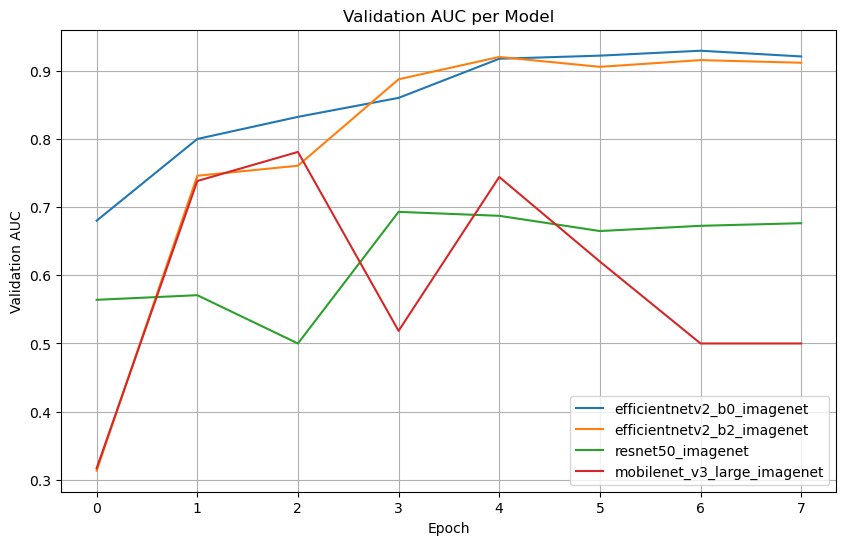

In [21]:
# Plot validation AUC curves for each trained model preset.
# This helps visually compare performance across model architectures.
plt.figure(figsize=(10, 6))
for preset, hist in results.items():
    plt.plot(hist.history['val_auc'], label=preset)
plt.title("Validation AUC per Model")
plt.xlabel("Epoch")
plt.ylabel("Validation AUC")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Best results summary
print("\n" + "#" * 10 + " Summary of Best Results " + "#" * 10)
for preset, hist in results.items():
    best_score = max(hist.history['val_auc'])
    best_epoch = np.argmax(hist.history['val_auc']) + 1
    print(f"\nModel: {preset}")
    print(f"Best AUC: {best_score:.5f}")
    print(f"Best Epoch: {best_epoch}")
print("#" * 46)



########## Summary of Best Results ##########

Model: efficientnetv2_b0_imagenet
Best AUC: 0.92916
Best Epoch: 7

Model: efficientnetv2_b2_imagenet
Best AUC: 0.92002
Best Epoch: 5

Model: resnet50_imagenet
Best AUC: 0.69294
Best Epoch: 4

Model: mobilenet_v3_large_imagenet
Best AUC: 0.78078
Best Epoch: 3
##############################################


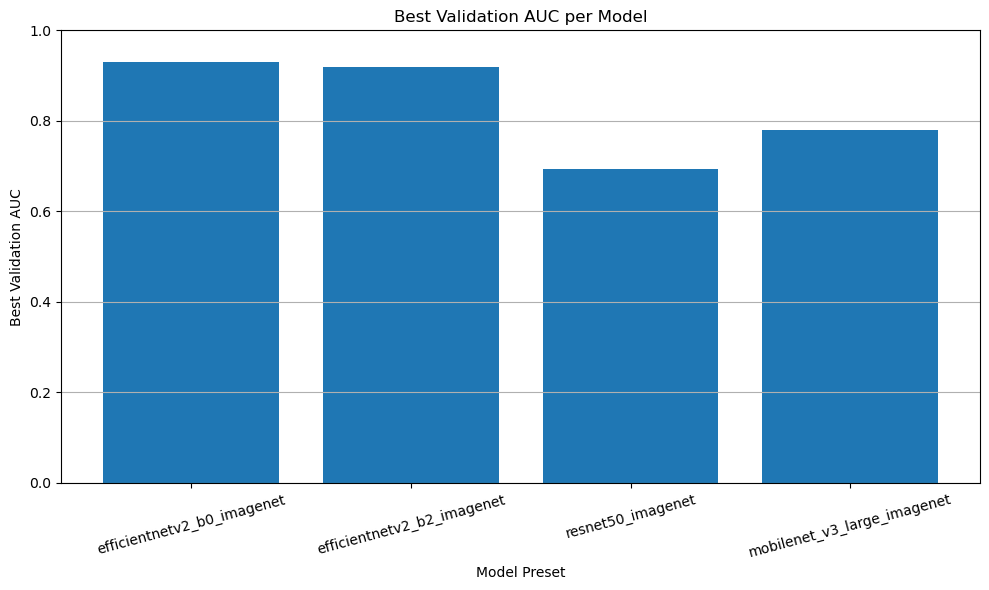

In [23]:
# Collect best scores per model
model_names = []
best_aucs = []
best_epochs = []

for preset, hist in results.items():
    best_score = max(hist.history['val_auc'])
    best_epoch = np.argmax(hist.history['val_auc']) + 1
    model_names.append(preset)
    best_aucs.append(best_score)
    best_epochs.append(best_epoch)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, best_aucs)
plt.title("Best Validation AUC per Model")
plt.xlabel("Model Preset")
plt.ylabel("Best Validation AUC")
plt.ylim(0.0, 1.0)
plt.xticks(rotation=15)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


#### Prediction

In [24]:
# Load a trained model from disk and evaluate it on the test set.
# Handles both labeled (for evaluation) and unlabeled (inference-only) test sets.
# Optionally saves predictions to a CSV file.
def load_and_test_model(preset, model_path, save_csv=False):
    print(f"\n=== Testing model: {preset} ===")

    # Load full model
    model = keras.models.load_model(model_path)

    # Set image size
    config.image_size = preset_image_sizes[preset]

    # Check for labels in test set
    has_labels = "target" in testing_df.columns

    # Prepare test dataset
    testing_features = dict(testing_df[FEAT_COLS])
    testing_ids = testing_df.isic_id.values

    decode_fn = build_decoder(with_labels=has_labels, target_size=config.image_size)

    if has_labels:
        # If labels exist, build labeled test dataset.
        testing_labels = testing_df["target"].values
        testing_ds = build_dataset(
            testing_ids, testing_hdf5, testing_features, testing_labels,
            batch_size=config.batch_size, shuffle=False, augment=False,
            cache=False, decode_fn=decode_fn
        )
        
        # Apply feature space transformation.
        testing_ds = testing_ds.map(
            lambda x, y: ({"images": x["images"], "features": feature_space(x["features"])}, y),
            num_parallel_calls=tf.data.AUTOTUNE)

        # Get predictions
        preds = model.predict(testing_ds).squeeze()

        # True labels
        y_true = []
        for _, labels in testing_ds:
            y_true.extend(labels.numpy())
        y_true = np.array(y_true)

        y_pred = (preds >= 0.5).astype(int)

        # Metrics
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=3))
        print("AUC:", roc_auc_score(y_true, preds))

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
        plt.title(f"{preset} - Confusion Matrix")
        plt.show()

    else:
        # If no labels are present, build unlabeled dataset.
        testing_ds = build_dataset(
            testing_ids, testing_hdf5, testing_features,
            batch_size=config.batch_size, shuffle=False, augment=False,
            cache=False, decode_fn=decode_fn
        )

        # Apply feature space transformation.
        testing_ds = testing_ds.map(
            lambda x: {"images": x["images"], "features": feature_space(x["features"])},
            num_parallel_calls=tf.data.AUTOTUNE)

        preds = model.predict(testing_ds).squeeze()
        y_true = y_pred = None
        print("No labels found in testing_df — skipping evaluation metrics.")
        
    
    # === Visualization ===


    # Show image samples
    inputs = next(iter(testing_ds))
    images = inputs["images"] if has_labels else inputs["images"]

    plt.figure(figsize=(10, 4))
    for i in range(min(3, len(images))):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Prediction: {preds[i]:.2f}')
        plt.axis('off')
    plt.suptitle(f'{preset} Predictions on Sample Images', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Save to CSV
    if save_csv:
        df_out = pd.DataFrame({
            "isic_id": testing_ids,
            "prediction": preds
        })
        if has_labels:
            df_out["target"] = y_true
        df_out.to_csv(f"{preset}_predictions.csv", index=False)
        print(f"Saved predictions to {preset}_predictions.csv")

    return preds, y_true, y_pred



=== Testing model: efficientnetv2_b0_imagenet ===


Loading Images :   0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
No labels found in testing_df — skipping evaluation metrics.


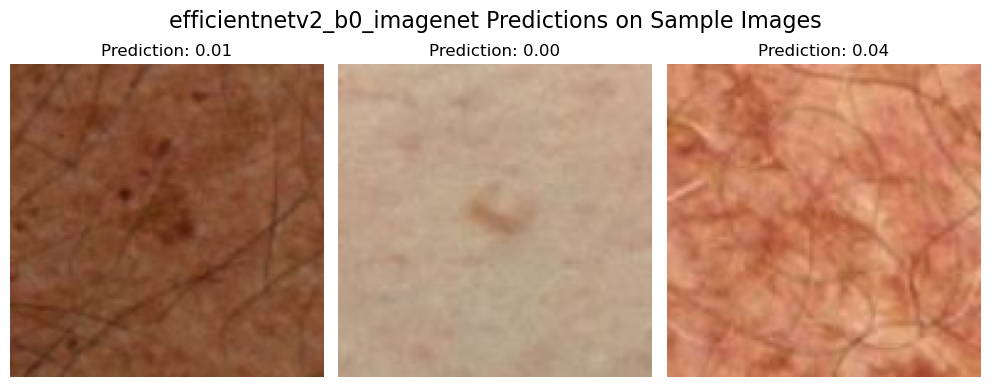

Saved predictions to efficientnetv2_b0_imagenet_predictions.csv

=== Testing model: efficientnetv2_b2_imagenet ===


Loading Images :   0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
No labels found in testing_df — skipping evaluation metrics.


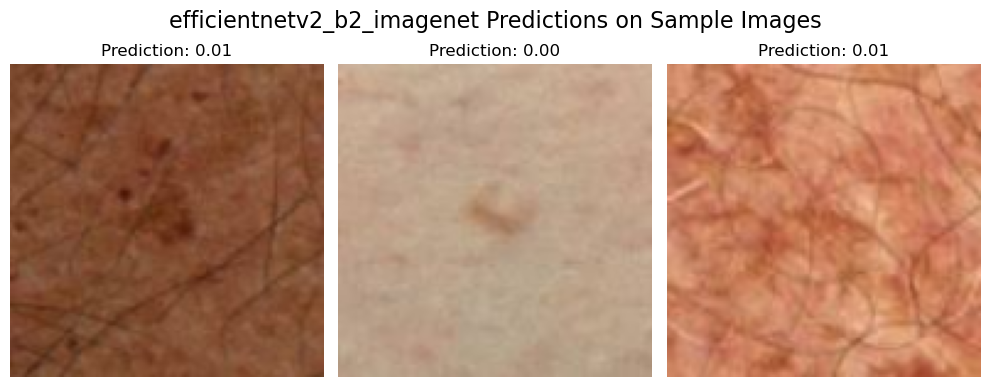

Saved predictions to efficientnetv2_b2_imagenet_predictions.csv

=== Testing model: resnet50_imagenet ===


Loading Images :   0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
No labels found in testing_df — skipping evaluation metrics.


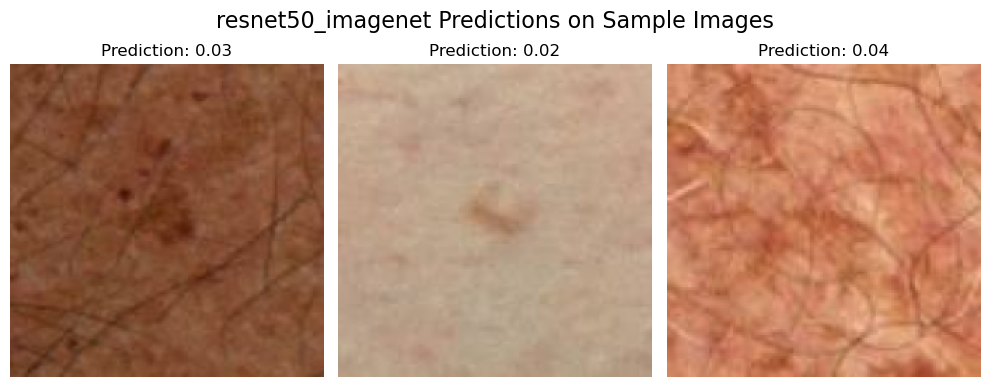

Saved predictions to resnet50_imagenet_predictions.csv

=== Testing model: mobilenet_v3_large_imagenet ===


Loading Images :   0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
No labels found in testing_df — skipping evaluation metrics.


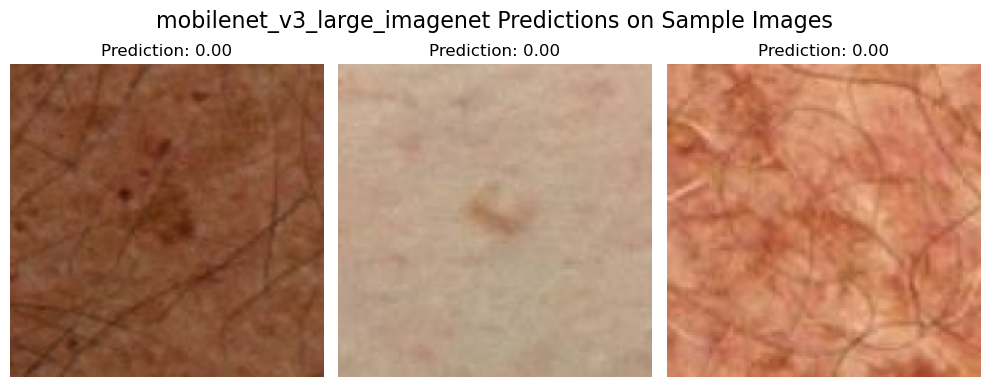

Saved predictions to mobilenet_v3_large_imagenet_predictions.csv


In [25]:
# Evaluate each trained model on the test set and store results.
# For each preset:
# - Load the saved model from disk.
# - Run inference and compute metrics (if labels are available).
# - Save predictions to CSV.
# - Store predictions, true labels, and binary outputs in the `results` dictionary
results = {}
for preset in config.preset_list:
    model_path = f"{preset}_model.keras"
    preds, y_true, y_pred = load_and_test_model(preset, model_path, save_csv=True)
    results[preset] = {"preds": preds, "y_true": y_true, "y_pred": y_pred}
